In [4]:
1//(1/0.999)

0.0

In [7]:
import torch


In [8]:
import numpy as np

In [9]:
bc = lambda y,p: - ( y*np.log(p) + (1-y)*np.log(1-p) )

In [11]:

criterion = torch.nn.BCELoss()

In [13]:
torch.nn.functional.cross_entropy(torch.tensor([[0.1,0.9],[0.7,0.3]]), 
                                  torch.tensor([[0,1.],[1,0.]]),reduction ='none')

tensor([0.3711, 0.5130])

In [401]:
torch.tensor([[0.1,0.9],[0.7,0.3]]).clamp(min=0.0001)

tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])

In [45]:
t_1 =torch.sigmoid(torch.tensor([[0,1.],
                            [1,0.]]))

In [41]:
a_1 =torch.sigmoid(torch.tensor([[0.1,0.9],
                            [0.7,0.3]]))

In [ ]:
(batch[0].shape[1] - self.chunk_size + 1)//self.chunk_size

In [395]:
ki = torch.randint(0,2,(2,10,1))
ki = ki/ki.sum(2)[:,:,None]
ki



tensor([[[1.],
         [nan],
         [1.],
         [nan],
         [1.],
         [1.],
         [nan],
         [nan],
         [nan],
         [1.]],

        [[1.],
         [1.],
         [nan],
         [nan],
         [1.],
         [1.],
         [nan],
         [nan],
         [1.],
         [1.]]])

In [553]:
gam = 5
ten = torch.tensor([0.01,0.2,0.3])
dist =  torch.distributions.Beta(gam*ten,gam*(1-ten))

In [557]:
torch.exp(dist.log_prob(torch.tensor([0.06,0.5
                                      ,0.3])
                       ))

tensor([0.6278, 0.5000, 1.8298])

In [558]:
from board_env import *


C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-

In [559]:
a_b = Board()

In [564]:
for i in a_b.territories[:,0]:
    print(i)

0
0
0
0
0
0
0
0
0
0


In [492]:
1.3146e+00

1.3146

In [398]:
dist = torch.distributions.Categorical(ki[:,-1])
dist.entropy()

tensor([1.1921e-07, 1.1921e-07])

In [221]:
a = 2816#2840
a = 257#2840

a_ = [(i,i+256) for i in range(0, a- 256    ,256-1)  ]
print(a_ +[ (a_[-1][1] -1 , a) ])

[(0, 256), (255, 257)]


In [95]:
print( [ (j[1]-j[0]) for j in   [(i,i+256) for i in range(0, a-256,256-1)  ]  ] )


[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]


In [318]:
import random 
random.randrange(3)

0

In [358]:
part_0  = np.random.choice(np.where([0,1,0,1,0])[0])
torch.tensor([
                                                        [
                                                         [part_0],
                                                         [np.around(0.929,2)]
                                                        ]
                                                        ],requires_grad =False)[:,:,0][:,0]

tensor([3.], dtype=torch.float64)

In [347]:
a = [1]
a.pop(random.randrange(len(a)-1))
a

ValueError: empty range for randrange()

In [320]:
tensor = torch.tensor([[1, 2, 2],
                   [3, 3, 4],
                   [5, 5, 5]])

dim = 1
max_values, max_indices = torch.max(tensor, dim=dim)

# Create a mask where values are equal to the maximum
mask = (tensor == max_values.unsqueeze(dim))

# Randomly select indices where the mask is True

# Use the random indices to break ties
max_indices[mask.sum(1)>1] = torch.argmax(mask.int(),dim=1)[mask.sum(1)>1]

max_indices


tensor([1, 2, 0])

In [315]:
import scipy

ModuleNotFoundError: No module named 'scipy'

In [313]:
import numpy as np

torch.tensor(np.random.choice(torch.where(torch.tensor([1,0,0,1,0,1]))[0]))[None]

tensor([5])

In [254]:
torch.where(mask)

(tensor([0, 0, 1, 2, 2, 2]), tensor([1, 2, 2, 0, 1, 2]))

In [248]:
torch.argmax(mask.int(),dim=1)

tensor([1, 2, 0])

In [260]:

tensor = mask.int()

indices = torch.where(tensor == 1)

# Generate random indices for each row
random_indices = torch.randint(0, tensor.shape[1], size=(tensor.shape[0],))

# Select the random indices from the indices of 1s for each row
selected_indices = torch.gather(indices[1], 0, random_indices)

In [262]:
random_indices

tensor([2, 0, 2])

In [261]:
tensor,selected_indices


(tensor([[0, 1, 1],
         [0, 0, 1],
         [1, 1, 1]], dtype=torch.int32),
 tensor([2, 1, 2]))

In [256]:
selected_indices

tensor([2, 2, 2])

In [234]:
max_indices[mask.sum(1)>1]

tensor([1, 0])

In [228]:
mask.sum(1)>1

tensor([ True, False,  True])

In [225]:
max_indices

tensor([1, 2, 0])

In [224]:
random_indices

tensor([2, 1, 0])

In [191]:
m.argmax(dim=1)

tensor([0, 1])

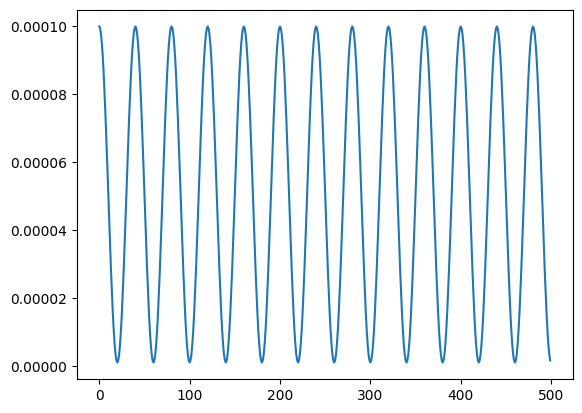

In [216]:
import torch.nn as nn
import matplotlib.pyplot as plt
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
model = SimpleNN(2,2,2)

my_optimizer = torch.optim.AdamW(model.parameters(),
                lr=0.0001)

my_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( my_optimizer, 
                                                20, eta_min=1e-6)

#my_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(my_optimizer, T_0=5, T_mult=2, eta_min=1e-6)



lr_ = []
for i in range(500):
    #lr_.append(my_lr_scheduler.get_lr()[0])
    lr_.append(my_optimizer.param_groups[0]["lr"])
    my_lr_scheduler.step()
plt.plot(lr_)

In [217]:
5e-4

0.0005

In [178]:
a =torch.tensor([[0,5,0,2,0],[1,0,3,0,0]])
m = torch.tensor([[1,0,1,0,1],[0,1,0,1,0]])

mt = a*m
valid_ind = m.argmax(dim=1)
max_ind = torch.argmax(mt,dim=1)


print(torch.nonzero(m))
print(max_ind)
print(torch.where(torch.sum(mt,dim=1) ==0))

zero_rows = torch.where(torch.sum(mt,dim=1) ==0)[0]
print('here',zero_rows)
#print(torch.where(valid_ind[:,[0]] ==  torch.where(torch.sum(mt,dim=1) ==0)))
print(mt, valid_ind[zero_rows,]    )

print(valid_ind[:,0] == zero_rows   )





max_ind[torch.where(torch.sum(mt,dim=1) ==0)] = valid_ind[torch.where(torch.sum(mt,dim=1) ==0),0]

print(max_ind)


tensor([[0, 0],
        [0, 2],
        [0, 4],
        [1, 1],
        [1, 3]])
tensor([0, 0])
(tensor([0, 1]),)
here tensor([0, 1])
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]) tensor([[0, 0],
        [0, 2]])


RuntimeError: The size of tensor a (5) must match the size of tensor b (2) at non-singleton dimension 0

In [187]:
list(max_ind[torch.where(torch.sum(mt,dim=1) ==0)].shape)

[2]

In [190]:
valid_ind.repeat( list(max_ind[torch.where(torch.sum(mt,dim=1) ==0)].shape)+[1,1])

tensor([[[0, 0],
         [0, 2],
         [0, 4],
         [1, 1],
         [1, 3]],

        [[0, 0],
         [0, 2],
         [0, 4],
         [1, 1],
         [1, 3]]])

tensor([[0, 0],
        [0, 2],
        [0, 4],
        [1, 1],
        [1, 3]])
tensor([0, 0])
(tensor([1]),)
here tensor([1])
tensor([[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]) tensor([[0, 2]])
tensor([False, False, False,  True,  True])
tensor([0, 0])


In [58]:
a_1[:,:],t_1[:,:]

(tensor([[0.5250, 0.7109],
         [0.6682, 0.5744]]),
 tensor([[0.5000, 0.7311],
         [0.7311, 0.5000]]))

In [48]:
torch.nn.BCELoss(reduction ='none')(a_1[:,0], 
                                  t_1[:,0]
                                   )

tensor([0.6944, 0.5914])

In [25]:
torch.argmax(torch.tensor([ 1.5020e-02, -4.6089e-03, -1.3334e-02,  2.0343e-04, -4.3803e-03,
          1.0656e-02,  3.3403e-03, -8.5943e-03, -2.4768e-02,  8.9168e-03,
          9.9040e-03,  1.7217e-03, -1.4346e-02,  4.5131e-03,  2.0226e-02,
          1.3239e-02, -3.4073e-03,  4.4389e-03,  1.2133e-02,  6.0024e-03,
         -1.3568e-02,  1.6063e-03, -7.6509e-03,  5.0171e-03, -9.0722e-03,
          1.6037e-03,  1.1047e-02, -3.4669e-03, -4.7848e-03, -9.7910e-03,
         -6.2496e-03, -9.5539e-03]))#,  4.9830e-01,  5.0170e-01]

tensor(14)

In [28]:
import torch

# Create a tensor and require gradients
tensor = torch.tensor([3., 3.], requires_grad=True)
tensor_2 = torch.tensor([3., 3.], requires_grad=True)

# Perform an operation that creates a gradient
output = tensor.sum()



output = torch.cat((output[None],tensor_2),axis =0).sum()
# Calculate gradients
print(output.requires_grad,output)

output.backward()

# Print the gradient version
print(tensor.grad._version)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [59]:
# import torch library
import torch

# create tensors with requires_grad = true
x = torch.tensor([4.0], requires_grad =True)
k = torch.tensor(2.0, requires_grad =False)

#x[0] = torch.tensor(3.0, requires_grad =True)

# print the tensor
print("x:", x)

# define a function y for the tensor, x

y = x[0]*k + 1
print("y:", y)

# Compute gradients using backward function for y
y.backward()

# Access the gradients using x.grad
dx = x.grad
print("x.grad :", dx)

x: tensor([4.], requires_grad=True)
y: tensor(9., grad_fn=<AddBackward0>)
x.grad : tensor([2.])


In [53]:
torch.nn.functional.one_hot ,requires_grad =False

Docstring:
one_hot(tensor, num_classes=-1) -> LongTensor

Takes LongTensor with index values of shape ``(*)`` and returns a tensor
of shape ``(*, num_classes)`` that have zeros everywhere except where the
index of last dimension matches the corresponding value of the input tensor,
in which case it will be 1.

See also `One-hot on Wikipedia`_ .

.. _One-hot on Wikipedia:
    https://en.wikipedia.org/wiki/One-hot

Arguments:
    tensor (LongTensor): class values of any shape.
    num_classes (int):  Total number of classes. If set to -1, the number
        of classes will be inferred as one greater than the largest class
        value in the input tensor.

Returns:
    LongTensor that has one more dimension with 1 values at the
    index of last dimension indicated by the input, and 0 everywhere
    else.

Examples:
    >>> F.one_hot(torch.arange(0, 5) % 3)
    tensor([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [1, 0, 0],
            [0, 1, 0]])
    >>> F.one_ho

In [51]:
torch.tensor([[[1,1,1]],[[2,2,2]]]).to('cpu',requires_grad =False)

TypeError: to() received an invalid combination of arguments - got (str, requires_grad=bool), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


In [19]:
torch.cat( (torch.tensor([[[1,1,1]],[[2,2,2]]]).repeat(2,1,1),
              torch.tensor([[[1,1,1]],[[2,2,2]]])),dim=0)

              

tensor([[[1, 1, 1]],

        [[2, 2, 2]],

        [[1, 1, 1]],

        [[2, 2, 2]],

        [[1, 1, 1]],

        [[2, 2, 2]]])

In [4]:
import torch

def loop_with_overlap(tensor, chunk_size, overlap):
  """
  Loops through a PyTorch tensor in chunks with overlapping elements.

  Args:
    tensor: The PyTorch tensor to loop through.
    chunk_size: The size of each chunk.
    overlap: The number of elements to overlap between chunks.

  Yields:
    Each chunk of the tensor with overlap.
  """

  for i in range(0, len(tensor) - chunk_size + 1, chunk_size - overlap):
    yield tensor[i:i + chunk_size]

# Example usage
tensor = torch.arange(10)  # Create a tensor from 0 to 9
chunk_size = 3
overlap = 1

for chunk in loop_with_overlap(tensor, chunk_size, overlap):
  print(f"Chunk: {chunk}")

Chunk: tensor([0, 1, 2])
Chunk: tensor([2, 3, 4])
Chunk: tensor([4, 5, 6])
Chunk: tensor([6, 7, 8])


In [174]:
import numpy as np
class Hero_agent(int):
    def init_properties(self,agent_count,phases,cp=[],df=[],direct_action=True):
        #self.draw_count = 0
        self.init_win_count_iter(agent_count)
        self.init_move_count_epi(phases)
        self.cp = cp
        self.df = df
        self.direct_action = direct_action
        self.init_reward_concern(agent_count,cp=cp,df=df)
        
    def init_reward_concern(self,agent_count,cp=[],df=[]):
        if len(cp)==0:
            cp = [int(self)]
        self.concern=torch.tensor([(1 if i in cp 
                             else 
                             (-1 if i in df 
                                  else 0)) for i in range(1,agent_count+1) ])
        #self.concern_2 = self.concern
        #self.concern_2[self-1] =0
        
        self.multi_dependency = (sum(self.concern !=0)>1)
        
        
        

        
    def init_win_count_iter(self,agent_count):
        self.count_dict = {i:0 for i in range(1,agent_count+1)}
        self.count_draw_dict = {i:0 for i in range(1,agent_count+1)}
        self.draw_territory_count = 0
    def init_move_count_epi(self,phases):
        self.bad_move_count = 0
        self.bad_move_phase_count = {i:0 for i in phases}
        self.move_count =  {i:0 for i in phases}        
    
    def model_def(self, model):
        self.model =model

    def action_predict(self,data):
        return self.model.action_predict(data)
    def save_models(self):
        self.model.save_models()

    def process_reward(self,rewards,step,hero_steps):
        if self.multi_dependency and self.direct_action:
            return (rewards*self.concern.to(rewards.device)).sum(-1)[:step][hero_steps][:,None]
        elif self.multi_dependency and not self.direct_action:
            base_rew = torch.zeros( rewards[:step,self-1][hero_steps].shape)
            #print(base_rew)

            hero_step_list  = np.arange(0,step)[hero_steps]
            for i,j in zip(hero_step_list[:-1],hero_step_list[1:]):
                if j-i>1:
                    #print(j,i,rewards[i:j],(rewards[i:j]*self.concern),(rewards[i:j]*self.concern).sum())
                    base_rew[i]+= (rewards[i:j]*self.concern).sum()
            #print(base_rew,rewards[hero_step_list[-1]:],(rewards[hero_step_list[-1]:]*self.concern))
            base_rew[-1]+= (rewards[hero_step_list[-1]:]*self.concern).sum()
            
            return base_rew[:,None]
            
        else:
            return rewards[:step][hero_steps][:,None]
    
    #def model_forward_call(self,name,kwarg):
    #    return self.model_dict[name](**kwarg)
        

a = Hero_agent(1)

In [184]:
a.init_properties(3,[1,2,3],cp=[1],df=[2],direct_action=False)

In [186]:
a.process_reward(torch.tensor([[1,2,2],[2,2,3],[3,4,1],[3,4,1]]),4,[0,3])

tensor([[-2.],
        [-1.]])

In [1]:
import gymnasium as gym
import os
#import gym
import numpy as np

import collections
import pickle
import tqdm

from stable_baselines3.common.buffers import ReplayBuffer


import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tyro
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from typing import Optional

import functools
import random
from copy import copy

import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete, Box, Dict

from pettingzoo import AECEnv



import gymnasium


from pettingzoo.utils import agent_selector, wrappers

from gymnasium.utils import EzPickle



from statistics import NormalDist

import pygame

from typing import Any , Generic, Iterable, Iterator, TypeVar
ActionType = TypeVar("ActionType")


C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
C:\Users\31721\.conda\envs\DL_project\lib\site-packages\pkg_resources\__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-

In [2]:
from Utilities.new_models import *
import utils_gym
import env_model_class_2


from board_env import *



%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import clear_output, display

In [6]:
import numpy as np
class Hero_agent(int):
    def init_properties(self,agent_count,phases):
        #self.draw_count = 0
        self.init_win_count_iter(agent_count)
        self.init_move_count_epi(phases)
        

        
    def init_win_count_iter(self,agent_count):
        self.count_dict = {i:0 for i in range(1,agent_count+1)}
        self.count_draw_dict = {i:0 for i in range(1,agent_count+1)}
        self.draw_territory_count = 0
    def init_move_count_epi(self,phases):
        self.bad_move_count = 0
        self.bad_move_phase_count = {i:0 for i in phases}
        self.move_count =  {i:0 for i in phases}        
    
    def model_def(self, model):
        self.model =model

    def action_predict(self,data):
        return self.model.action_predict(data)
    def save_models(self):
        self.model.save_models()
    
    #def model_forward_call(self,name,kwarg):
    #    return self.model_dict[name](**kwarg)
        

a = Hero_agent(1)
a.init_properties(3,[1,2,3])

In [3]:
class DDQN_module:
    def __init__(self, qnet_config_dict, actor_config_dict,args,device,run_name,agent,writer=None):

        self.agent = agent
        self.run_name =run_name 
        self.actor_config_dict = actor_config_dict
        self.qnet_config_dict = qnet_config_dict
        self.args = args
        self.device = device
        self.writer = writer
        
        self.actor = Actor_ddqn(**self.actor_config_dict).to(self.device)
        self.qf1 = QNetwork(**self.qnet_config_dict).to(self.device)
        self.qf1_target = QNetwork(**self.qnet_config_dict).to(self.device)
        self.target_actor = Actor_ddqn(**self.actor_config_dict).to(self.device)
        
        
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.qf1_target.load_state_dict(self.qf1.state_dict())
        self.q_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.args.learning_rate)
        self.actor_optimizer = optim.Adam(list(self.actor.parameters()), lr=self.args.learning_rate)

    def action_predict(self,data):
        return self.actor(data)

    def train_write(self,data,iteration,epoch):
        #data = rb.sample(self.args.batch_size)
        qf1_a_values, qf1_loss, actor_loss = self.train(data)
        self.write(qf1_a_values, qf1_loss, actor_loss,epoch,iteration)

    #def calculate_loss
    
    def train(self,data):


        
        with torch.no_grad():
            collected_t_next = data.next_observations[:,-1]
            next_state_actions = self.target_actor(data.next_observations[:,:-1])
            qf1_next_target = self.qf1_target(data.next_observations[:,:-1], next_state_actions)

            
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * (self.args.gamma**(collected_t_next+1)).view(-1) * (qf1_next_target).view(-1)
    
        qf1_a_values = self.qf1(data.observations[:,:-1], data.actions).view(-1)

        criterion = nn.SmoothL1Loss()
        
        qf1_loss = criterion(qf1_a_values, next_q_value)

        
        #qf1_loss = nn.functional.mse_loss(qf1_a_values, next_q_value)
        
        # optimize the model
        self.q_optimizer.zero_grad()
        qf1_loss.backward()
        self.q_optimizer.step()
        
        #if global_step % args.policy_frequency == 0:
        actor_loss = -self.qf1(data.observations[:,:-1], self.actor(data.observations[:,:-1])).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
    
        # update the target network
        for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
            target_param.data.copy_(self.args.tau * param.data + (1 - self.args.tau) * target_param.data)
        for param, target_param in zip(self.qf1.parameters(), self.qf1_target.parameters()):
            target_param.data.copy_(self.args.tau * param.data + (1 - self.args.tau) * target_param.data)
        return qf1_a_values, qf1_loss, actor_loss
        

    def write(self,qf1_a_values, qf1_loss, actor_loss,epoch,iteration):
        
        ind_epoch = epoch + (iteration-1)*self.args.update_epochs
        self.writer.add_scalar(f"losses/{self.agent}/qf1_values", qf1_a_values.mean().item(), ind_epoch)
        
        self.writer.add_scalar(f"losses/{self.agent}/qf1_loss", qf1_loss.item(), ind_epoch)
        self.writer.add_scalar(f"losses/{self.agent}/actor_loss", actor_loss.item(), ind_epoch)
        
    def save_models(self):
        newpath = r'./models/'+ self.run_name +'/'+str(self.agent)
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        torch.save(self.actor.state_dict(), newpath+"/actor.pt")
        torch.save(self.qf1.state_dict(), newpath+"/qf1.pt")
        torch.save(self.qf1_target.state_dict(), newpath+"/qf1_target.pt")
        torch.save(self.target_actor.state_dict(), newpath+"/target_actor.pt")  
    def load_models(self):
        newpath = r'./models/'+ self.run_name +'/'+str(self.agent)
        self.actor.load_state_dict(torch.load(newpath+"/actor.pt"))
        self.qf1.load_state_dict(torch.load(newpath+"/qf1.pt"))
        self.qf1_target.load_state_dict(torch.load(newpath+"/qf1_target.pt"))
        self.target_actor.load_state_dict(torch.load(newpath+"/target_actor.pt")) 
        

                                          
                   
        
        

In [5]:
class evaluate_model:
    def __init__(self,Args,param_dict =dict({}),run_name="MountainCar-v0__exp1_ddqn___1__1724315565"
                 ):
        # #### Configurations

        self.args = Args()#tyro.cli(Args)
        self.param_dict = param_dict
        self.update_arg(param_dict=param_dict)

        
        #self.args.batch_size = int(self.args.num_envs * self.args.num_steps)
        self.args.minibatch_size = int(self.args.batch_size // self.args.num_minibatches)
        #self.args.num_iterations = self.args.total_timesteps // self.args.batch_size
        self.gam = self.args.gamma
        #self.args.minibatch_size = 256#128 
        self.num_steps = self.args.num_steps#120000#1000000
        self.num_iterations = self.args.num_iterations
        self.episode_time_lim = self.args.episode_time_lim
        self.num_episodes = self.args.num_episodes


        
        
        
        self.run_name = run_name

        self.writer = None

        # TRY NOT TO MODIFY: seeding
        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        torch.manual_seed(self.args.seed)
        
        torch.backends.cudnn.deterministic = self.args.torch_deterministic
        
        self.device = torch.device("cuda" if torch.cuda.is_available() and self.args.cuda else "cpu")
        
        
        self.playe_r = 1#"agent_1" #
        

        
        self.action_shape = (2,)

        self.env_config = dict(render_mode = 'rgb_array', default_attack_all  = True,
                            agent_count  = 4
                               ,use_placement_perc=True,render_=False)

        self.env = env_risk(**self.env_config)
        
        self.env.reset(seed=42)


            

        
        self.total_agents  = len(self.env.possible_agents)
        self.total_phases = len(self.env.phases)
        
        sample_obs = self.obs_converter(torch.tensor(self.env.last()[0]['observation']),
                                        num_classes = self.total_agents+1
                                       )
        
        self.ob_space_shape = sample_obs.shape #env.observation_space(playe_r)['observation'].shape
        self.action_mask_shape = self.env.observation_space(self.playe_r)['action_mask'].shape
        
        #self.device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

        
        
        self.agent_list = list(self.env.possible_agents)
        
        
        
        
       
        self.the_hero_agent = 1

        
        self.qnet_config_dict = dict(action_space = self.env.action_space(self.playe_r
                                                                         ).shape[0],
                                    ob_space=np.prod(self.ob_space_shape
                                                    )+np.prod(self.action_mask_shape)
                                         +1*( self.total_agents -1) #the current_agent +1#who actor agent was
                                         +1*(self.total_phases -1)#the current phase
                                         +1 # the number of troops
                               )
        self.actor_config_dict =  dict(env=self.env,
                        action_space = self.env.observation_space(self.playe_r)['action_mask'].shape[0],
                        ob_space=np.prod(self.ob_space_shape)+np.prod(self.action_mask_shape)
                                         +1*( self.total_agents-1) #the current_agent +1#who actor agent was
                                         +1*(self.total_phases -1)#the current phase
                                         +1 # the number of troops
                               )
        
        self.hero_agent_count = 2
        self.hero_agents_list = {i:Hero_agent(i) for i in range(1,self.hero_agent_count+1) } # this is a list , need to pass it as an argument
        
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_properties(self.total_agents,self.env.phases)        
            
            self.hero_agents_list[i].model_def(model = DDQN_module( self.qnet_config_dict, self.actor_config_dict,
                                                                   self.args,device = self.device,run_name=self.run_name,agent=i)
                                                )

            self.hero_agents_list[i].model.load_models()
            

            #self.target_actor.load_state_dict(self.actor.state_dict())
            #self.qf1_target.load_state_dict(self.qf1.state_dict())
            #self.q_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.args.learning_rate)
            #self.actor_optimizer = optim.Adam(list(self.actor.parameters()), lr=self.args.learning_rate)

    def update_arg(self,param_dict=dict({})):
       for i,j in param_dict.items():
           setattr(self.args,i,j)
    

    
    def obs_converter(self,  data, num_classes = 4, col =0 ):

        if col != None:
            return torch.concat((nn.functional.one_hot(data[:,col].detach().long(), 
                                                        num_classes = num_classes),
                                      data[:,~col,None]
                                ),axis=1
                               )[:,1:].to(self.device)
    
    def map_agent_phase_hot(self, data,num_classes = 3):
        return nn.functional.one_hot(torch.tensor(data),num_classes = num_classes)[1:].to(self.device)
    
    def map_agent_phase_vector(self, data,num_classes = 3):
        return nn.functional.one_hot(data[:,0].long(), 
                                                            num_classes = num_classes)[:,1:].to(self.device)

    
    def train_loop_init(self):
        self.gamma_t = {i:0 for i in self.env.possible_agents}
        
        
        self.draw_count = 0

        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_win_count_iter(self.total_agents )
        
        
        self.start_time = time.time()
        self.global_step = 0

    def reset_moves_hero_agents(self):
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_move_count_epi(self.env.phases)    
    
    def run_eval_loop(self):
        """
        ### Run training loop
        """


        env = env_risk(**(self.env_config | {"render_mode" : None, "bad_mov_penalization" : 0.01,"render_":False}))
        env.reset(42)
        
        self.train_loop_init()
        
        for iteration in range(1, self.num_iterations+1):
            self.sample(env,iteration)
            print(iteration)

    def sample(self,env,iteration):
        with torch.no_grad():
            # sample `worker_steps` from each worker
            #there are no worker steps... rather there are full episodes

            step = 0
            fault_condition = False
            clear_output(wait=True)
            phase = 0
        
            
            for episode in range(self.num_episodes):#num_episodes):
                
                total_rewards = {i:0 for i in env.possible_agents} #i can report this
                action=1
                
                if fault_condition:
                    env = env_risk(**(self.env_config | {"render_mode" : None,"bad_mov_penalization" : 0.01,"render_":False#False
                                                        })
                                      )#game.env(render_mode=None)

                curren_epi = episode + (iteration-1)*self.num_episodes
                env.reset(curren_epi) #for riplication
                
                fault_condition = False
                step_count = 0
                
                self.reset_moves_hero_agents()
                is_draw = 0
                
                #draw_territory_count = 0
                #is_third = 0

                for agent in env.agent_iter():
                    e_t = env.terminations
                    if sum(e_t.values()) <(self.total_agents-1):
                        observation, reward, termination, truncation, info = env.last()
        
                        observation['observation'] =  self.obs_converter(
                                                        torch.tensor(
                                                            observation['observation']
                                                        ).to(self.device,dtype=torch.float32),
                                                        num_classes = self.total_agents+1)
                        
                        #episodes[step] = curren_epi
                        #obs[step] = observation['observation']#torch.Tensor(observation['observation']).to(self.device) #sould i not add it .... meaning this is the last observation after the player dies
                        #action_masks[step] = torch.Tensor(observation['action_mask']).to(self.device)
                        
                        #curr_agent = agent#int(agent[-1])
                        #current_agent[step] = 
                        curr_agent = agent
                        #current_phase[step] = 
                        phase = env.phase_selection
                        
                        phase_mapping = self.map_agent_phase_hot(phase,num_classes = self.total_phases).float()
                        
                        curr_agent_mapping = self.map_agent_phase_hot(int(curr_agent)-1,
                                                                      num_classes = self.total_agents 
                                                                     ).float()
                        
                        #current_troops_count[step] = torch.Tensor([env.board.agents[i].bucket for i in env.possible_agents]).to(self.device)
                    

                        model_in = torch.Tensor(torch.hstack((observation['observation'].reshape(-1),torch.tensor(observation['action_mask'].reshape(-1)).to(self.device),
                                           phase_mapping,
                                            curr_agent_mapping,
                                           torch.tensor([env.board.agents[curr_agent].bucket ]).to(self.device)))[None,:]#.repeat(3,axis = 0)
                                                ).float()
                        
                        #if e_t[curr_agent]:
                            #print('heeee')
                            
                        if termination or truncation: #this never happens ... the agent is removed from the current agent list and processed after the end of the cycle
                            
                            action = None

                            act = self.actor(torch.Tensor(model_in).to(self.device))
                            #act = self.
                            #act, logprob, _, value = agent_mod.get_action_and_value(model_in)
                            #values[step] = value.flatten() # so even if we are removing the guy ... we need to know what is the action he would 
                                                                #have taken at this point and what would have been its value
                            #actions[step] = act #even after going what would have been
                            #logprobs[step] = logprob        
                        else:
                            mask = observation["action_mask"]
                            if ( agent not in self.hero_agents_list):
        
                                
                                action = env.action_space(agent).sample()
                                part_0 =np.random.choice(np.where(env.board.calculated_action_mask(agent))[0])
                                action = torch.Tensor([[[part_0],[np.around(action[1],2)]]]).to(self.device)
                                action = action[:,:,0]

                                if not( observation['action_mask'][action[:,0].long()]) : 
                                    fault_condition =True
                                    print(agent,observation['action_mask'],action[:,0].long())
                                    break


                            
                            else:
                                action = self.hero_agents_list[curr_agent].action_predict(torch.Tensor(model_in).to(self.device))
                                #action = self.actor(torch.Tensor(model_in).to(self.device))
                            #actions[step] = action
                            curr_agent_ = int(curr_agent)
        
                            if (not observation['action_mask'][action[:,0].long()]) : 
                                fault_condition =True
                                #self.faulting_player = agent

                                

                                


                                if  curr_agent_ in self.hero_agents_list:
                                    print(observation['action_mask'],action[:,0].long())
                                    print(env.board.calculated_action_mask(agent))
                                    print(model_in)
                                    break
                                    self.hero_agents_list[curr_agent_].bad_move_count+=1
                                    self.hero_agents_list[curr_agent_].bad_move_phase_count[phase]+=1  # when is the where_is_it_performing_bad_really
                                    #print('here',agent, action, observation['action_mask'])
                            
        
                            #if  curr_agent_ in self.hero_agents_list:
                            #    self.hero_agents_list[curr_agent_].move_count[int(current_phase[step][0])]+=1  
                            #if self.the_hero_agent == curr_agent:
                                #move_count[int(current_phase[step][0])]+=1        
        
        
                        #print('here',agent, action)
                        if action != None :
                            act_2 = action.detach().cpu().numpy()[0]#list([action.detach().cpu().numpy()[0][0], max(action.detach().cpu().numpy()[0][1],0.1) ])
                            act_2 = list([act_2[0], max(act_2[1],0.001) ])
                        else:
                            act_2 = action

                        
                        env.step(act_2 if action != None else None) 

                        if action != None:
                            curr_reward_list =  env.curr_rewards
                            if (step_count == (self.episode_time_lim-1)):
                                is_draw=1
                                curr_reward_list = {i:-100 for i in env.possible_agents }
        
        
                        #if action == None:
                        #    print('heeee')
                        #    rewards[step] = np.zeros(self.total_agents) # should i keep it -1? .... hm i dont think so .
                        #    dones[step] = np.zeros(self.total_agents) # frankly the guys is already done so we really dont have to do anything here.... this is the state post termination for a loser 
                        #    # but btw this is for the next agent ... action == None means in the last action the previous agent would have been removed.
                        #    #values[step] = 
                        #else:
        #
                        #    rewards_2[step] = torch.Tensor([env.curr_rewards[i] for i in env.possible_agents]).to(self.device)
                        #    curr_reward_list =  env.curr_rewards
                        #    
                        #    if (step_count == (self.episode_time_lim-1)):
                        #        is_draw=1
                        #        curr_reward_list = {i:-100 for i in env.possible_agents }
        #
                        #    for i in env.possible_agents:
                        #        if i != curr_agent:
                        #            self.gamma_t[i]+=1
                        #        else:
                        #            self.gamma_t[i] =0
        #
                        #        if (step_count == (self.episode_time_lim-1)):
                        #            cr_rew = -100
                        #            term = True
                        #        else:
                        #            cr_rew = env.curr_rewards[i]
                        #            term = env.terminations[i]
#
                        #        next_step_ = step-self.gamma_t[i]
                        #        rewards[next_step_,i-1] += (self.args.gamma**self.gamma_t[i])*cr_rew
                        #        t_next[next_step_,i-1] = self.gamma_t[i]
                        #        dones[next_step_,i-1] = torch.Tensor([term]).to(self.device) #so the panetly has to be added but attributions is really difficult
        
                        #list_curr_reward_list = np.array(list(curr_reward_list.values()))
                        
                        #if sum(curr_reward_list.values()) == -300:
                            #print('here')
                            #is_draw=1
        
                        
                        for age_i in env.possible_agents:
                            
                            total_rewards[age_i]+=curr_reward_list[age_i] #env.curr_rewards[age_i] if (step_count != episode_time_lim) else -100
                                    
                        
                        step +=1
                        self.global_step+=1
        
                    else:
                        print('done:',env.terminations,#env.terminations.values(),
                              ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", episode )
                        break    
                

In [58]:

exp_3 = dict(
exp_name = 'exp3_ddqn_lr_bs_1',
learning_rate = 0.001,
batch_size = 512,
gamma = 0.99,
num_steps=120000,
num_iterations = 1,
episode_time_lim = 10000,
num_episodes = 1

    
)

In [ ]:
evaluate_model

In [65]:
T = evaluate_model(Args,param_dict = exp_3,
                   run_name = 'MountainCar-v0__exp1_ddqn___1__1724315565')

In [66]:
T.run_eval_loop()

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1] tensor([29], device='cuda:0')
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3.]],
       device='cuda:0')
1


In [73]:




hidden = T.hero_agents_list[2].model.actor.network( torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3.]],
       device='cuda:0'))
logits = T.hero_agents_list[2].model.actor.actor_1(hidden)
probs = Categorical(logits=logits)

In [74]:
probs.probs

tensor([[0.0297, 0.0316, 0.0309, 0.0323, 0.0323, 0.0319, 0.0315, 0.0365, 0.0295,
         0.0301, 0.0312, 0.0319, 0.0310, 0.0322, 0.0318, 0.0334, 0.0311, 0.0317,
         0.0306, 0.0283, 0.0320, 0.0306, 0.0299, 0.0291, 0.0303, 0.0307, 0.0314,
         0.0315, 0.0327, 0.0315, 0.0291, 0.0316]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [39]:
class Actor_ddqn_(nn.Module):
    def __init__(self, action_space = None, ob_space=None):
        super().__init__()
        #self.fc1 = nn.Linear(ob_space, 256)
        #self.fc2 = nn.Linear(256, 256)
        #self.fc_mu = nn.Linear(256, action_space)


        self.network = nn.Sequential(
            layer_init(nn.Linear(ob_space, 256)),
            nn.GELU(),
            layer_init(nn.Linear(256, 256)),
            nn.GELU(),
            layer_init(nn.Linear(256, 64)),
            nn.GELU(),
            #layer_init(nn.Linear(64, 64)),
            #nn.GELU(),
        )
        self.actor_1 = layer_init(nn.Linear(64, action_space), std=0.01)
        self.actor_2 = nn.Sequential(layer_init(nn.Linear(64, 2), std=0.01), nn.Softmax(dim=1),)


    def forward(self, x):
        
        hidden = self.network(x)
        logits = self.actor_1(hidden)
        probs = Categorical(logits=logits)

        action_1 = probs.sample()[:,None]
        action_2 = self.actor_2(hidden)[:,[0]]

        action = torch.concat((action_1,action_2),1)

        return action#* self.action_scale + self.action_bias




In [40]:
a1 = Actor_ddqn_(action_space = 5, ob_space=5)

In [43]:
hidden = a1.network(torch.Tensor([[1,2,3,4,5]]))
logits = a1.actor_1(hidden)
probs = Categorical(logits=logits)

#probs.sample()[:,None]

In [50]:
for i in range(20):
    print(probs.sample())

tensor([3])
tensor([0])
tensor([4])
tensor([3])
tensor([4])
tensor([4])
tensor([0])
tensor([1])
tensor([4])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([3])
tensor([0])
tensor([2])
tensor([4])
tensor([4])
tensor([0])
tensor([3])


In [42]:
a1(torch.Tensor([[1,2,3,4,5]]))

tensor([[0.0000, 0.4998]], grad_fn=<CatBackward0>)